In [104]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

In [105]:
# Función para gráficar histogramas de variables numéricas (hecho con ayuda de deepseek r1)
def plot_numeric_analysis(df, numeric_cols, figsize=(15, 10)):
    """Gráfica histogramas de variables numéricas, adaptando los ejes a la data."""
    if not numeric_cols:
        print("No hay columnas numéricas para graficar.")
        return

    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    if len(numeric_cols) <= 2:
        figsize = (8, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Análisis de Variables Numéricas', fontsize=16)

    # Aplanar los ejes para simplificar la iteración
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for idx, col in enumerate(numeric_cols):
        # Se extrae la data de la columna ignorando valores nulos
        data = df[col].dropna()
        # Se calcula un margen del 5% del rango para que el gráfico no esté muy pegado a los bordes
        if not data.empty:
            margin = 0.05 * (data.max() - data.min())
            x_min = data.min() - margin
            x_max = data.max() + margin
        else:
            x_min, x_max = 0, 1

        # Graficamos el histograma usando bins automáticos para mejor adaptación
        sns.histplot(data=df, x=col, ax=axes[idx], bins='auto')
        axes[idx].set_title(f'Distribución de {col}')
        axes[idx].set_xlim(x_min, x_max)

    # Ocultar subplots no utilizados
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)

    # Ajustamos el layout dejando espacio para el título general
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Función para detectar outlayers con el método IQR, extremos y no extremos
def iqr_method(column):
    """Detecta outliers usando el método IQR."""
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    return pd.Series([column>upper_bound, column<lower_bound, column>extreme_upper_bound, column<extreme_lower_bound], 
                     index=['outliers_upper', 'outliers_lower', 'extreme_upper', 'extreme_lower'])

# Función para realizar un análisis exploratorio de una tabla (mejorado con ayuda de claude 3.7 sonnet)
def analisis_exploratorio(name, df):
    """Realiza un análisis exploratorio de una tabla."""
    total_chars = 125
    print("="*total_chars)
    string = f"Análisis de la tabla {name}"
    print('|' + string.center(total_chars-2) + '|')
    print("="*total_chars)
    print(f"Dimensiones: {df.shape}")
    
    # Expresión regular para identificar columnas ID
    id_pattern = re.compile(
        r'^id_.*|.*_id$|^id$',  # Empieza con id_, termina con _id, o es exactamente id
        flags=re.IGNORECASE
    )
    id_cols = [col for col in df.columns if id_pattern.fullmatch(col)]
    
    # Separar columnas numéricas y no numéricas
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in id_cols]
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    
    # Normalizar strings y manejar IDs
    for col in non_numeric_cols:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
    
    # Agregar IDs a no numéricas para estadísticas especiales
    non_numeric_cols += id_cols

    non_numeric_stats = []
    if non_numeric_cols:
        for col in non_numeric_cols:
            stats = {
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': '-',
                'Desviación Estándar': '-',
                'Mínimo': df[col].min() if col in id_cols else '-',
                'Mediana': '-',
                'Máximo': df[col].max() if col in id_cols else '-'
            }
            non_numeric_stats.append(stats)
    
    numeric_stats = []
    cols_to_remove = []
    if numeric_cols:
        for col in numeric_cols:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({0, 1}):
                df[col] = df[col].astype('boolean')
                cols_to_remove.append(col)
            else:
                numeric_stats.append({
                    'Columna': col,
                    'Valores Únicos': df[col].nunique(),
                    'Media': df[col].mean(),
                    'Desviación Estándar': df[col].std(),
                    'Mínimo': df[col].min(),
                    'Mediana': df[col].median(),
                    'Máximo': df[col].max()
                })
        # Remover columnas convertidas a boolean
        numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats = []
    
    for col in df.columns:
        is_numeric = col in numeric_cols
        
        stats = {
            'Columna': col,
            'Valores Únicos': df[col].nunique(),
            'Media': df[col].mean() if is_numeric else '-',
            'Desviación Estándar': df[col].std() if is_numeric else '-',
            'Mínimo': df[col].min() if is_numeric or col in id_cols else '-',
            'Mediana': df[col].median() if is_numeric else '-',
            'Máximo': df[col].max() if is_numeric or col in id_cols else '-',
            'Tipos de datos': df[col].apply(type).unique() if len(df[col].apply(type).unique()) == 1 else '\n'.join(str(t) for t in df[col].apply(type).unique()),
            'NaN/Null': df[col].isnull().sum(),
            'Duplicados únicos': len(df[(df.duplicated(subset=[col], keep='first'))&(df[col].notnull())]),
            'Duplicados totales': len(df[(df.duplicated(subset=[col], keep=False))&(df[col].notnull())])
        }
        
        # Agregar información de outliers solo para columnas numéricas
        if is_numeric:
            iqr_stats = iqr_method(df[col])
            stats.update({
                'Outlayers (IQR extreme_lower)': iqr_stats['extreme_lower'].sum(),
                'Outlayers (IQR lower)': iqr_stats['outliers_lower'].sum(),
                'Outlayers (IQR upper)': iqr_stats['outliers_upper'].sum(),
                'Outlayers (IQR extreme_upper)': iqr_stats['extreme_upper'].sum()
            })
        else:
            stats.update({
                'Outlayers (IQR extreme_lower)': '-',
                'Outlayers (IQR lower)': '-',
                'Outlayers (IQR upper)': '-',
                'Outlayers (IQR extreme_upper)': '-'
            })
            
        all_stats.append(stats)
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats_df = pd.DataFrame(all_stats).set_index('Columna')
    inconsistencias_stats_df = all_stats_df.T
    
    print('\nEstadísticas descriptivas y problemas de calidad:')
    print(inconsistencias_stats_df.to_markdown(index=True))
    
    if numeric_cols:
        plot_numeric_analysis(df, numeric_cols)
    return


In [106]:
source_file = '../data/processed/Airbnb_Cleaned.csv'
df = pd.read_csv(source_file, low_memory=False)

## Verificación de la limpieza

|                                              Análisis de la tabla airbnb_data                                             |
Dimensiones: (73125, 20)

Estadísticas descriptivas y problemas de calidad:
|                               | log_price          | property_type   | room_type       | accommodates       | bathrooms          | bedrooms           | beds               | city            | neighbourhood   | amenities       | review_scores_rating   | number_of_reviews   | cleaning_fee     | bed_type        | cancellation_policy   | instant_bookable   | host_identity_verified   | host_response_rate   | host_since      | host_has_profile_pic   |
|:------------------------------|:-------------------|:----------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:----------------|:----------------|:----------------|:-----------------------|:--------------------|:-----------------|:----------------|:----------------------|:----------

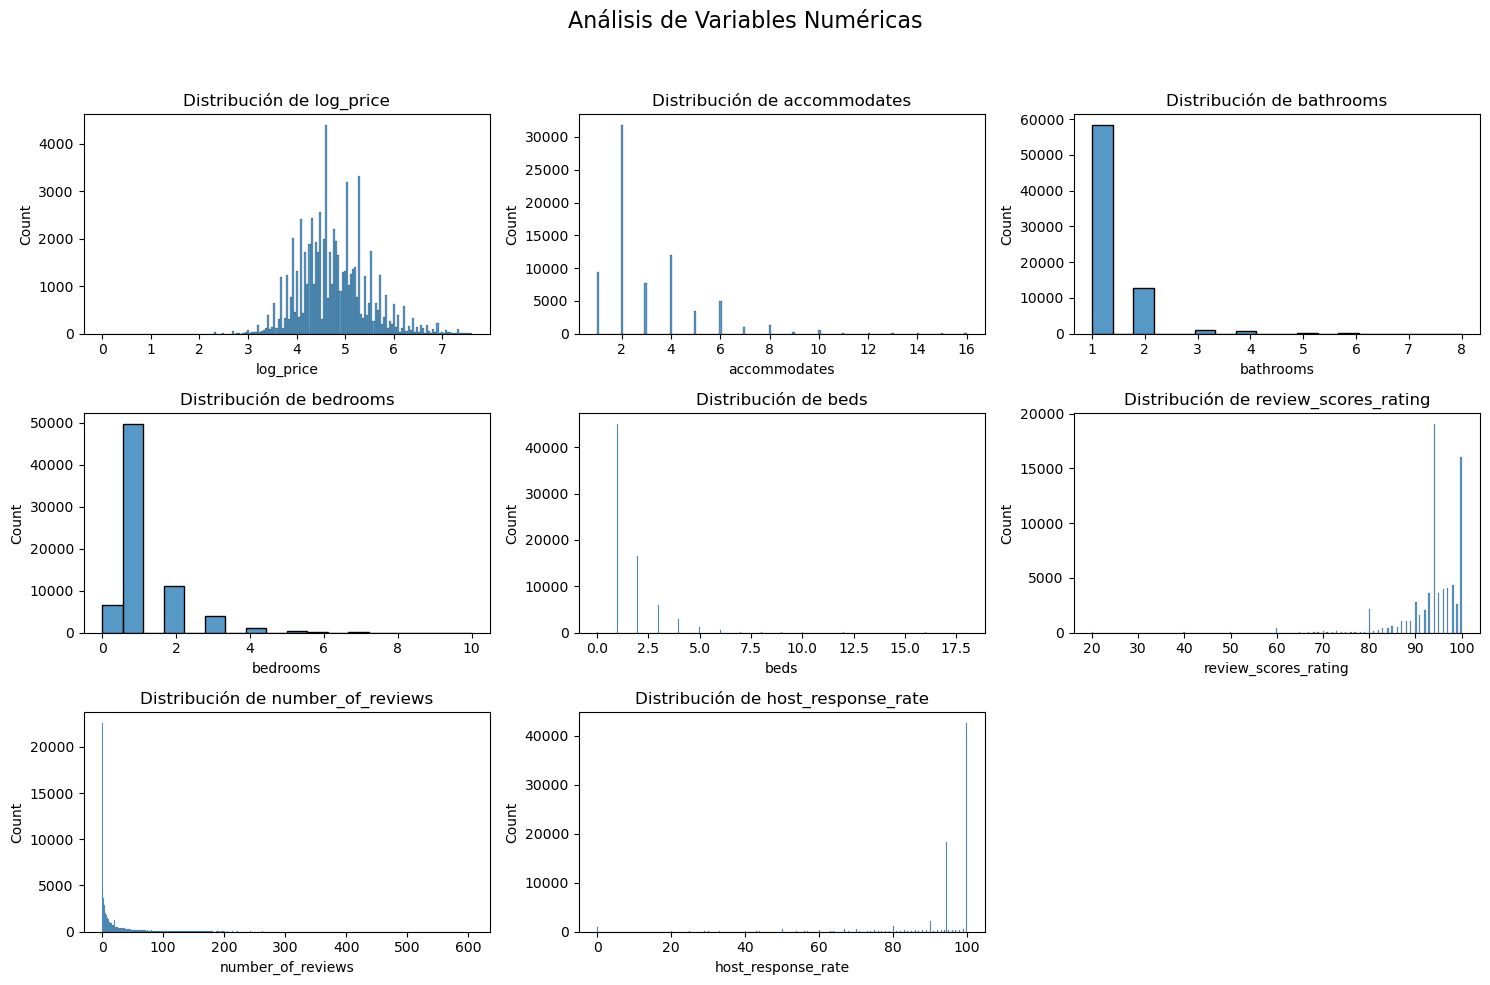

In [107]:
analisis_exploratorio('airbnb_data', df)

Se crea la variable number_of_amenities, que extrae el número de servicios disponibles a partir de la columna amenities (donde se encuentran listados entre llaves).

In [108]:
def extract_amenities_count(amenities_str):
    """Extrae el número de amenities de una cadena de texto con formato {amenity1,amenity2,...}"""
    if pd.isna(amenities_str) or amenities_str == '{}':
        return 0
    # Limpiamos la cadena y contamos las amenities
    amenities = amenities_str.strip('{}').split(',')
    return len([a for a in amenities if a.strip()])

# Creamos la nueva característica number_of_amenities
df['number_of_amenities'] = df['amenities'].apply(extract_amenities_count)
df.drop(columns=['amenities'], inplace=True)


Podemos generar también una columna para los host nuevos que identificamos en el EDA, además de marcar como host nuevos a aquellos que se unieron en los ultimos 90 días

In [109]:
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

# Encuentra la fecha más reciente
most_recent_date = df['host_since'].max()

# Función para determinar si un host es nuevo
def is_new_host(row):
    if not row['host_identity_verified'] and not row['host_has_profile_pic'] and row['host_since'] == most_recent_date:
        return True
    days_diff = (most_recent_date - row['host_since']).days
    new_host = days_diff <= 90
    return new_host

# Crear la nueva característica is_new_host
df['is_new_host'] = df.apply(is_new_host, axis=1)

# Caracteristicas temporales adicionales
df['host_days'] = (most_recent_date - df['host_since']).dt.days
df['host_years'] = df['host_days'] / 365
df['host_months'] = df['host_days'] / 30

# Eliminar la columna host_since
df.drop(columns=['host_since'], inplace=True)


Para columnas que no presentan una jerarquia/odrinalidad como `room_type, property_type y city` se utilizara OneHot encoding

In [110]:
# Aplicamos One-hot encoding
onehot_cols = ['room_type', 'property_type', 'city']
for col in onehot_cols:        
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat([df, dummies], axis=1)

# Eliminamos las columnas originales
df.drop(columns=onehot_cols, inplace=True)

A partir de la columna `review_scores_rating` se crearán nuevas categorías que clasificarán las calificaciones en diferentes niveles de calidad. Se definen cuatro categorías: 'Low', 'Medium', 'High', y 'Excellent', basadas en los rangos de puntuación.

In [111]:

# Categoría de calificación
df['rating_category'] = pd.cut(
    df['review_scores_rating'],
    bins=[0, 80, 90, 95, 100],
    labels=['Low', 'Medium', 'High', 'Excellent']
)

Utilizando `neighbourhood` y `log_price` se puede calcular el precio promedio de cada `neighbourhood` y así crear una característica `neighborhood_avg_price`. Esta transformación permite capturar la influencia de la ubicación en el precio, agrupando los datos a nivel de barrio para obtener un indicador del valor de la zona. Posteriormente, esta variable numérica se categoriza en cinco niveles mediante `pd.qcut()`, generando la característica `neighborhood_price_category` que clasifica los barrios desde "Very Low" hasta "Very High" según su precio medio. Finalmente, esta categorización se utiliza para identificar listados premium, combinándola con altas calificaciones.

In [ ]:
# Agrupamos las calificaciones por barrio
neighborhood_prices = df.groupby('neighbourhood')['log_price'].mean().reset_index()
neighborhood_prices.columns = ['neighbourhood', 'neighborhood_avg_price']
df = df.merge(neighborhood_prices, on='neighbourhood', how='left')

# Categorizamos los barrios por nivel de precio
df['neighborhood_price_category'] = pd.qcut(
    df['neighborhood_avg_price'],
    q=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

# Interacción entre ubicación premium y calidad
df['premium_listing'] = ((df['neighborhood_price_category'].isin(['High', 'Very High'])) & 
                         (df['review_scores_rating'] >= 95)).astype(bool)
df.drop(columns=['neighbourhood'], inplace=True)

Para las columnas `rating_category, bed_type, cancellation_policy y neighborhood_price_category` que contienen valores con una ordinalidad, ya que hay una jerarquia en ambas columnas, se utilizara Ordinal encoding para conservar dicha jerarquia.

In [113]:
ordinal_cols = ['rating_category', 'bed_type', 'cancellation_policy', 'neighborhood_price_category']
encoder = OrdinalEncoder()

# Aplicamos OrdinalEncoder
df_encoded = encoder.fit_transform(df[ordinal_cols])

# Asignamos los valores codificados a nuevas columnas
for i, col in enumerate(ordinal_cols):
    df[f'{col}_encoded'] = df_encoded[:, i]

# Eliminamos las columnas originales
df.drop(columns=ordinal_cols, inplace=True)

Escalamos columnas númericas

In [115]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('log_price')

# Aplicamos StandardScaler para normalizar las variables numéricas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_cols])

# Reemplazamos las columnas originales con las escaladas
for i, col in enumerate(numeric_cols):
    df[col] = df_scaled[:, i]

print(f"Se han escalado {len(numeric_cols)} variables numéricas.")

Se han escalado 16 variables numéricas.


Aplicamos feature selection con un método filter


Se han seleccionado 14 características con correlación absoluta > 0.1:
['log_price', 'accommodates', 'neighborhood_avg_price', 'bedrooms', 'beds', 'bathrooms', 'premium_listing', 'number_of_amenities', 'city_sf', 'cancellation_policy_encoded', 'cleaning_fee', 'neighborhood_price_category_encoded', 'room_type_shared room', 'room_type_private room']


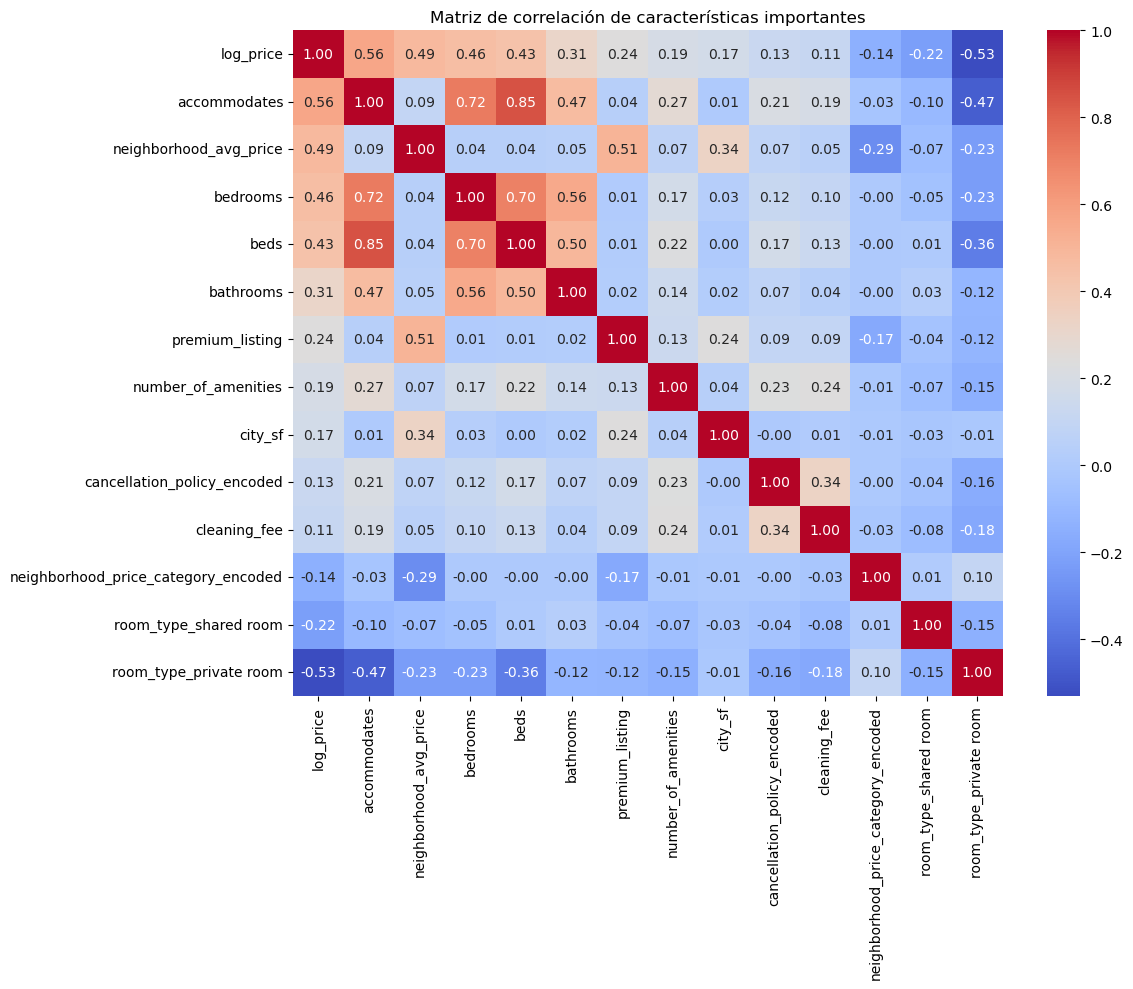

In [ ]:
# Hecho con ayuda de claude 3.7 sonnet

# Calculamos la matriz de correlación con la variable objetivo
target_col = 'log_price'
corr_matrix = df.corr()[target_col].sort_values(ascending=False)

# Seleccionamos variables con correlación absoluta por encima de un umbral
corr_threshold = 0.1
important_features = corr_matrix[abs(corr_matrix) > corr_threshold].index.tolist()

print(f"\nSe han seleccionado {len(important_features)} características con correlación absoluta > {corr_threshold}:")
print(important_features)

# Guardar nuevo dataset con características importantes
df_important = df[important_features]
df_important.to_csv('../data/processed/Airbnb_Feature_Engineered.csv', index=False)

# Visualización de correlaciones de las variables importantes
plt.figure(figsize=(12, 10))
corr_important = df[important_features].corr()
sns.heatmap(corr_important, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación de características importantes')
plt.tight_layout()
plt.show()